# Environment

In [171]:
import higlass
from higlass.client import View, Track, CombinedTrack
from higlass.tilesets import cooler, beddb, chromsizes, bigwig, Tileset
from cooler import Cooler, create_cooler
from cooler.util import binnify
import clodius

import os
import os.path as path
import pandas as pd
import numpy as np
import itertools
import negspy.coordinates as nc
import scipy.stats as stats

import matplotlib.pyplot as plt

def bed2ddb(filepath, uuid=None, **kwargs):
    from clodius.tiles.bed2ddb import get_2d_tileset_info, get_2D_tiles
    from clodius.tiles.utils import tiles_wrapper_2d

    return Tileset(
        uuid=uuid,
        tileset_info=lambda: get_2d_tileset_info(filepath),
        tiles=lambda tids: tiles_wrapper_2d(
            tids, lambda z, x, y: get_2D_tiles(filepath, z, x, y)[(x, y)]
        ),
        **kwargs
    )


# helper function to filter NAs and NaNs from a matrix
def filter_arr(x):
    return x[~np.isnan(x) & np.isfinite(x)]


# Annotations

In [61]:
annot_dir = path.join("..", "Results", "2019-10-24_higlass")
genes = beddb(path.join(annot_dir, "Data", "hg38", "gene-annotations-hg38.beddb"))

chrom_sizes_df = pd.read_csv(
    path.join(annot_dir, "hg38.chrom.sizes"),
    sep="\t",
    header=None,
    names=["chr", "size"]
)
chrom_sizes_series = pd.Series(
    data=chrom_sizes_df["size"].values,
    index=chrom_sizes_df["chr"].values,
)
chrom_sizes = chromsizes(path.join(annot_dir, "hg38.chrom.sizes"))

label_font_size = 18
chr_label_size = 30
annots_size = 150

chrom_labels = {
    p: Track(
        track_type=l + "-chromosome-labels",
        tileset=chrom_sizes,
        position=p,
        height=chr_label_size,
        width=chr_label_size,
        options={
            "fontSize": label_font_size,
            "showMousePosition": True,
        },
    ) for p, l in zip(["top", "bottom", "left", "right"], ["horizontal", "horizontal", "vertical", "vertical"])
}
chrom_grid = {
    p: Track(
        track_type=l + "-chromosome-grid",
        tileset=chrom_sizes,
        position=p,
        height=chr_label_size,
        width=chr_label_size,
        options={
            "fontSize": label_font_size,
            "showMousePosition": True,
        },
    ) for p, l in zip(
        ["top", "bottom", "left", "right"],
        ["horizontal", "horizontal", "vertical", "vertical"])
}

gene_annots = {
    p: Track(
        track_type=l + "-gene-annotations",
        tileset=genes,
        position=p,
        height=annots_size,
        width=annots_size,
        options={
            "fontSize": label_font_size,
            "showMousePosition": True,
        },
    ) for p, l in zip(["top", "bottom", "left", "right"], ["horizontal", "horizontal", "vertical", "vertical"])
}

hg38 = nc.get_chrominfo("hg38")

# Load data

## Metadata

In [4]:
meta = pd.read_csv("config.tsv", sep="\t")
meta = meta.loc[meta.Include == "Yes", :]

SAMPLES = {
    "all": meta["Sample_ID"].tolist(),
    "tumour": meta.loc[(meta.Source == "Primary") & (meta.Type == "Malignant"), "Sample_ID"].tolist(),
    "benign": meta.loc[(meta.Source == "Primary") & (meta.Type == "Benign"), "Sample_ID"].tolist(),
    "primary": meta.loc[(meta.Source == "Primary"), "Sample_ID"].tolist(),
    "clines": meta.loc[(meta.Source == "Cell Line"), "Sample_ID"].tolist(),
}
meta

,Sample_ID,Label,Include,Source,Type,Sample_Colour,Type_Colour,Tissue,T2E
0,PCa13266,CPCG0268,Yes,Primary,Malignant,#7F3C8D,#1F77B4,Prostate,No
1,PCa13848,CPCG0366,Yes,Primary,Malignant,#11A579,#1F77B4,Prostate,Yes
2,PCa14121,CPCG0255,Yes,Primary,Malignant,#3969AC,#1F77B4,Prostate,No
3,PCa19121,CPCG0258,Yes,Primary,Malignant,#F2B701,#1F77B4,Prostate,Yes
4,PCa3023,CPCG0324,Yes,Primary,Malignant,#E73F74,#1F77B4,Prostate,Yes
5,PCa33173,CPCG0246,Yes,Primary,Malignant,#80BA5A,#1F77B4,Prostate,No
6,PCa40507,CPCG0342,Yes,Primary,Malignant,#E68310,#1F77B4,Prostate,Yes
7,PCa51852,CPCG0336,Yes,Primary,Malignant,#008695,#1F77B4,Prostate,Yes
8,PCa53687,CPCG0339,Yes,Primary,Malignant,#CF1C90,#1F77B4,Prostate,No
9,PCa56413,CPCG0331,Yes,Primary,Malignant,#F97B72,#1F77B4,Prostate,Yes


## Contact matrices

In [132]:
resolutions = [
    1000, 2000, 3000, 4000, 5000,
    10000, 20000, 30000, 40000, 50000,
    100000, 200000, 300000, 400000, 500000,
    1000000, 2000000, 3000000, 4000000, 5000000
][::-1]
min_resolution = 20000
colour_range = [
    "rgba(65, 105, 225, 1.0)",
    "rgba(255, 250, 250, 1.0)",
    "rgba(255, 25, 25, 1.0)"
]

mtx_dir = {
    "primary": path.join("..", "Data", "Processed", "2019-06-18_PCa-LowC-sequencing", "Contacts"),
    "clines": path.join("..", "..", "Data", "External", "Rhie_2019", "Contacts"),
}
mtx_files = {}
for s in SAMPLES["primary"]:
    mtx_files[s] = path.join(mtx_dir["primary"], s + ".mcool")

for s in SAMPLES["clines"]:
    mtx_files[s] = path.join(mtx_dir["clines"], s + ".mcool")

mtx_tilesets = {
    s: cooler(f)
    for s, f in mtx_files.items()
}

contacts = {
    s: {
        p: Track(
            track_type=pl + "heatmap",
            datatype="matrix",
            filetype="cooler",
            tileset=mtx_tilesets[s],
            height=height,
            options={
                "maxZoom": str(resolutions.index(min_resolution)),
                "colorbarPosition": "topRight",
                "showMousePosition": True,
                "name": meta.loc[meta["Sample_ID"] == s, "Label"].values[0],
                "colorRange": colour_range,
            }
        )
        for p, pl, height in zip(
            ["top", "right", "bottom", "left", "center"],
            ["horizontal-", "horizontal-", "horizontal-", "horizontal-", ""],
            #["linear-", "linear-", "linear-", "linear-", ""],
            [120, 120, 120, 120, 480],
        )
    }
    for s in mtx_files.keys()
}

## Structural variants

In [6]:
sv_dir = path.join("..", "Results", "2020-02-19_chromoplexy")
sv_track_dir = path.join(sv_dir, "Tracks")
breaks = pd.read_csv(
    path.join(sv_dir, "Graphs", "sv-breakpoints.paired.tsv"),
    sep="\t",
    header=0,
    index_col=False,
)

sv_files = {
    "1D": {
        s: path.join(sv_track_dir, s + ".breaks.beddb")
        for s in SAMPLES["tumour"]
    },
    "2D": {
        s: path.join(sv_track_dir, s + ".breaks.bed2ddb")
        for s in SAMPLES["tumour"]
    }
}
sv_tilesets = {
    "1D": {
        s: beddb(
            v,
            name=meta.loc[meta["Sample_ID"] == s, "Label"].values[0] + " Breaks"
        )
        for s, v in sv_files["1D"].items()
    },
    "2D": {
        s: bed2ddb(
            v,
            name=meta.loc[meta["Sample_ID"] == s, "Label"].values[0] + " Breaks"
        )
        for s, v in sv_files["2D"].items()
    }
}
svs = {
    "1D": {
        s: {
            p: Track(
                track_type=t + "bedlike",
                datatype="bedlike",
                filetype="beddb",
                position=p,
                tileset=sv_tilesets["1D"][s],
                options={
                    "showMousePosition": True,
                    "name": meta.loc[meta["Sample_ID"] == s, "Label"].values[0],
                    "labelPosition": "topLeft",
                    "labelColor": meta.loc[meta.Sample_ID == s, "Sample_Colour"].values[0],
                    "fillColor": meta.loc[meta.Sample_ID == s, "Sample_Colour"].values[0],
                },
            ) for p, t in zip(
                ["top", "bottom", "left", "right"],
                ["", "", "vertical-", "vertical-"])
        }
        for s in SAMPLES["tumour"]
    },
    "2D": {
        s: {
            p: Track(
                track_type=pl+"2d-rectangle-domains",
                datatype="2d-rectangle-domains",
                filetype="bed2ddb",
                position=p,
                tileset=sv_tilesets["2D"][s],
                height=50,
                width=50,
                options={
                    "showMousePosition": True,
                    "name": meta.loc[meta.Sample_ID == s, "Label"].values[0],
                    "labelPosition": "topLeft",
                    "labelColor": meta.loc[meta.Sample_ID == s, "Sample_Colour"].values[0],
                    "rectangleDomainFillColor": meta.loc[meta.Sample_ID == s, "Sample_Colour"].values[0],
                },
            )
            for p, pl in zip(
                ["top", "right", "bottom", "left", "center"],
                # later versions of HiGlass switch "horizontal"/"vertical" to "linear"
                ["horizontal-", "vertical-", "horizontal-", "vertical-", ""],
            )
        }
        for s in SAMPLES["tumour"]
    }
}

# Figures

## Structural variant that alters TAD boundaries without changing gene expression: T2E translocation to _RALGAPA1_

### Contact matrix

In [133]:
mut_sample = "PCa13848"

views = [View(
    tracks=[
        chrom_labels["top"],
        chrom_grid["top"],
        gene_annots["top"],
        chrom_labels["left"],
        chrom_grid["left"],
        gene_annots["left"],
        contacts[mut_sample]["top"],
        contacts[mut_sample]["center"],
    ],
    initialXDomain=[
        nc.chr_pos_to_genome_pos("chr14", 34000000, hg38),
        nc.chr_pos_to_genome_pos("chr14", 38000000, hg38)
    ],
    initialYDomain=[
        nc.chr_pos_to_genome_pos("chr21", 38000000, hg38),
        nc.chr_pos_to_genome_pos("chr21", 42000000, hg38)
    ],
)]

d, s, v = higlass.display(
    views=views,
    server_port=8192,
    zoom_syncs=[views],
    location_syncs=[views],
)
d

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'cnJuR_KJQLm_7u767iC8HA', 'tracks': {'top': [{'ty…

### Differential contact matrix

In [139]:
# get contact matrix from Cooler objects
sv_sample_id = "PCa13848"
nonsv_sample_id = "PCa53687"
pos = {
    "x": [
        nc.chr_pos_to_genome_pos("chr14", 35225000, hg38),
        nc.chr_pos_to_genome_pos("chr14", 36025000, hg38),
    ],
}

# contact matrix resolution
res = 20000

mut = Cooler(mtx_files[sv_sample_id] + "::/resolutions/" + str(res))
nonmut = Cooler(mtx_files[nonsv_sample_id] + "::/resolutions/" + str(res))

# get contact matrix values around the breakpoint
i, j = mut.extent("chr14:35400000-35900000")
mut_mat = mut.matrix()[i:j, i:j]
nonmut_mat = nonmut.matrix()[i:j, i:j]

# calculate the difference between the two contact matrices
# (< 0: more contacts in mutant, > 0: fewer contacts in mutant)
diff = np.log10(nonmut_mat / mut_mat)

half_idx = (
    [(i, j) for i in range(16) for j in range(16) if j >= i]
    + [(i, j) for i in range(16, 25) for j in range(16, 25) if j >= i]
)
overlapping = diff[ [i for i, _ in half_idx], [j for _, j in half_idx] ].flatten()
broken = diff[ 0:16, 16: ].flatten()

# calculate p-value for difference in contact frequencies between the overlapping and broken parts of the contact matrix
ttest_res = stats.ttest_ind(
    a = filter_arr(broken),
    b = filter_arr(overlapping),
    equal_var=False,
)
ttest_res

/home/james/.miniconda/envs/Davos/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


Ttest_indResult(statistic=6.378452174485695, pvalue=1.0394982648405165e-09)

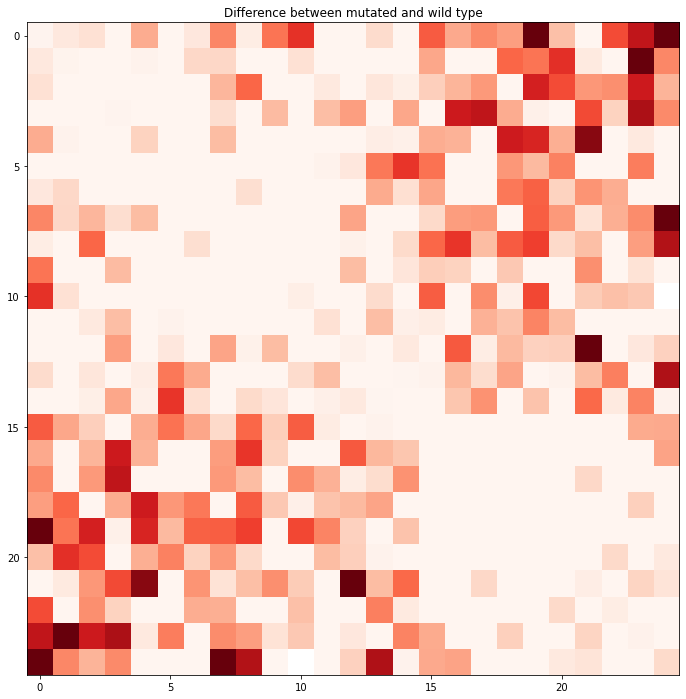

In [128]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title("Difference between mutated and wild type")
plt.imshow(
    diff,
    vmin=-0.2,
    vmax=0.5,
    cmap="Reds",
)
ax.set_aspect('equal')
fig.savefig(
    path.join("..", "Results", "2020-09-25_T2E-translocation-investigation", "diff-nonmut.altered-TAD.pdf")
)

## Structural variant that alters gene expression without altering TAD boundaries: _RIMBP2_

### Contact matrix

In [135]:
sv_sample_id = "PCa58215"
nonsv_sample_id = "PCa13266"

pos = [
    {
        "x": [
            nc.chr_pos_to_genome_pos("chr12", 129500000, hg38),
            nc.chr_pos_to_genome_pos("chr12", 132000000, hg38)
        ],
        "y": [
            nc.chr_pos_to_genome_pos("chr12", 105000000, hg38),
            nc.chr_pos_to_genome_pos("chr12", 106500000, hg38)
        ]
    },
    {
        "x": [
            nc.chr_pos_to_genome_pos("chr12", 105000000, hg38),
            nc.chr_pos_to_genome_pos("chr12", 132000000, hg38)
        ],
        "y": [
            nc.chr_pos_to_genome_pos("chr7", 105000000, hg38),
            nc.chr_pos_to_genome_pos("chr7", 150000000, hg38)
        ]
    },
    {
        "x": [
            nc.chr_pos_to_genome_pos("chr7", 105000000, hg38),
            nc.chr_pos_to_genome_pos("chr7", 150000000, hg38)
        ],
        "y": [
            nc.chr_pos_to_genome_pos("chr7", 105000000, hg38),
            nc.chr_pos_to_genome_pos("chr7", 150000000, hg38)
        ]
    },
]
    
    
v = [
    View(
        tracks=[
            chrom_labels["top"],
            gene_annots["top"],
            chrom_labels["left"],
            gene_annots["left"],
            contacts[sv_sample_id]["top"],
            contacts[sv_sample_id]["center"],
        ],
        initialXDomain = pos[i]["x"],
        initialYDomain = pos[i]["y"],
    ) for i in range(3)
]

d, s, c = higlass.display(
    views=[v[0], v[2], v[1]],
)
d

HiGlassDisplay(viewconf={'editable': True, 'views': [{'uid': 'd4Lj1luZTf2ti4k0QLLW_g', 'tracks': {'top': [{'ty…

### Differential contact matrix

In [173]:
sv_sample_id = "PCa58215"
nonsv_sample_id = "PCa13266"

mut = Cooler(mtx_files[sv_sample_id] + "::/resolutions/" + str(res))
nonmut = Cooler(mtx_files[nonsv_sample_id] + "::/resolutions/" + str(res))

# get contact matrix values around the breakpoint
i, j = mut.extent("chr12:130000000-130760000")
mut_mat = mut.matrix()[i:j, i:j]
nonmut_mat = nonmut.matrix()[i:j, i:j]

half_idx = (
    [(i, j) for i in range(13) for j in range(13) if j >= i]
    + [(i, j) for i in range(13, 25) for j in range(13, 25) if j >= i]
)

# calculate the difference between the two contact matrices
# (< 0: more contacts in mutant, > 0: fewer contacts in mutant)
diff = np.log10(nonmut_mat / mut_mat)

overlapping = diff[ [i for i, _ in half_idx], [j for _, j in half_idx] ].flatten(),
overlapping = overlapping[0]
broken = diff[ 0:13, 13: ].flatten(),
broken = broken[0]

ttest_res = stats.ttest_ind(
    a = filter_arr(broken),
    b = filter_arr(overlapping),
)
ttest_res

Ttest_indResult(statistic=0.8100675063907965, pvalue=0.41829300258798974)

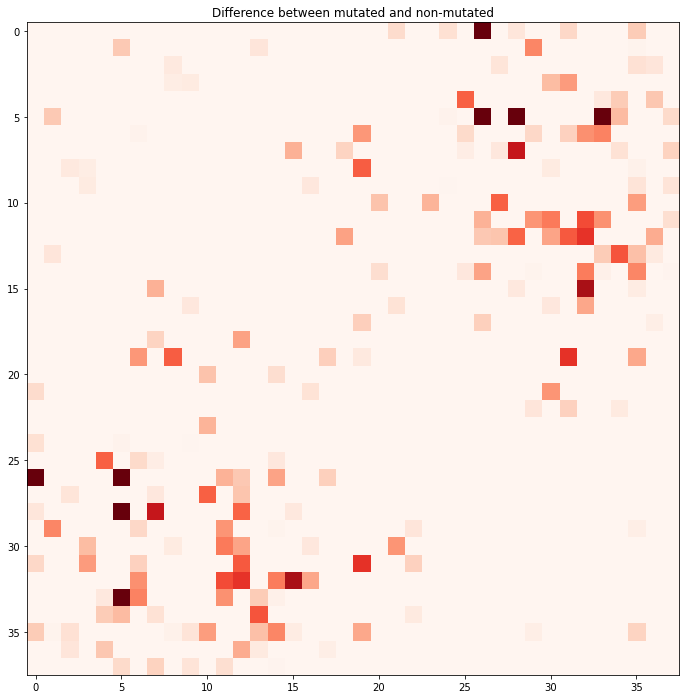

In [174]:
# plot differences between mutant and nonmutant/benign samples
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title("Difference between mutated and non-mutated")
plt.imshow(
    diff,
    vmin=0,
    vmax=0.5,
    cmap="Reds",
)
ax.set_aspect('equal')
fig.savefig(
    path.join("..", "Results", "2020-09-25_T2E-translocation-investigation", "diff-nonmut.no-altered-TAD.pdf")
)